In [23]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline

In [24]:
df = pd.read_csv("./../out.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)

In [25]:
df = df.loc[0:999] # first 1000 segments

In [26]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer 
tfidf_vec = TfidfVectorizer()
tfidf = tfidf_vec.fit_transform(df['segment'])

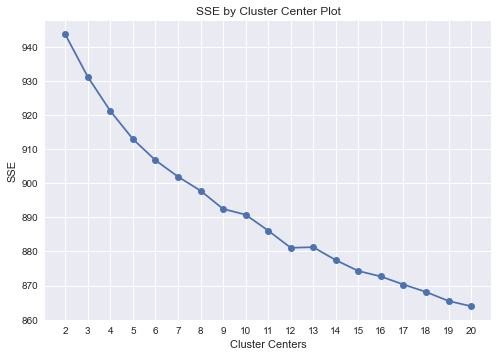

In [27]:
def elbow_method(data, K):
    iters = range(2, K + 1)
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters = k, 
                        init='k-means++', 
                        max_iter=300, 
                        n_init=10, 
                        random_state=0)
                        .fit(data)
                        .inertia_)

    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

elbow_method(tfidf, 20)
# Elbow occurs at k=12

In [11]:
from sklearn.metrics import cohen_kappa_score, adjusted_rand_score, silhouette_score
def silhouette_method(data, K):
    iters = range(2, K + 1)
    score = []
    for k in iters:
        model = KMeans(n_clusters = k, init='k-means++', max_iter=300, n_init=10, random_state=0)
        cluster_labels = model.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        print("For n_clusters =" + str(k) + "The average silhouette_score is :" + str(silhouette_avg))

silhouette_method(tfidf, 10)
# silhouette score at k = 5 reach maximium

For n_clusters =2The average silhouette_score is :0.0188282922131685
For n_clusters =3The average silhouette_score is :0.020360317547895915
For n_clusters =4The average silhouette_score is :0.021878952049417387
For n_clusters =5The average silhouette_score is :0.02411698597169442
For n_clusters =6The average silhouette_score is :0.02070496745600827
For n_clusters =7The average silhouette_score is :0.021294190248959715
For n_clusters =8The average silhouette_score is :0.021280699411655467
For n_clusters =9The average silhouette_score is :0.02276655268407279
For n_clusters =10The average silhouette_score is :0.020138836738422962


In [12]:
k = 5
tfidf_kmeans = KMeans(n_clusters = k, init='k-means++', max_iter=300, n_init=10, random_state=0)
tfidf_kmeans_pred = tfidf_kmeans.fit_predict(tfidf)
# https://stackoverflow.com/questions/60293351/how-tfidf-value-is-used-in-k-means-clustering

C:\Users\zwang684\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


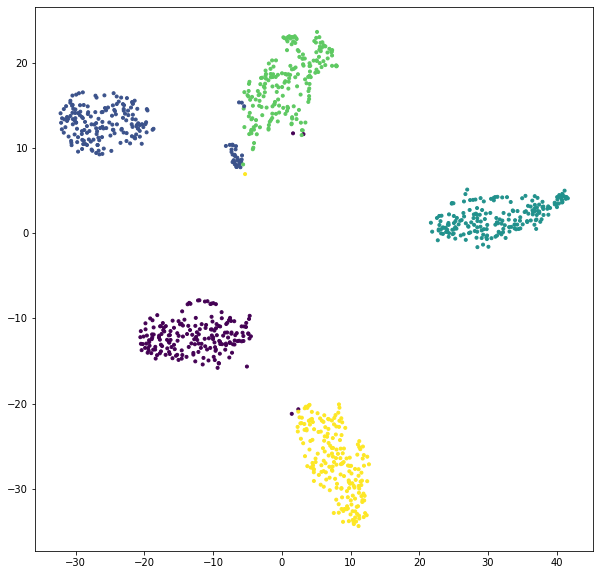

In [13]:
# dimension reduction--visualization
from sklearn.manifold import TSNE
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.decomposition import TruncatedSVD
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

tfidf_reduced = TruncatedSVD(n_components=k, random_state=0).fit_transform(tfidf)

tfidf_embedded = TSNE(n_components=2, 
                    perplexity=50, 
                    init='pca', # globally more stable to initialization
                    learning_rate = 'auto',
                    n_iter=1000, 
                    random_state=0).fit_transform(tfidf_reduced)
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(tfidf_embedded[:, 0], tfidf_embedded[:, 1], marker = ".", c = tfidf_kmeans.labels_)
plt.show()

In [14]:
"""
map model labels to actual labels
"""
pred_map = dict()
for i in range(0, 5):
    a = tfidf_vec.transform(df['segment'][i * 200 : i * 200 + 199])
    count = np.bincount(tfidf_kmeans.predict(a))
    np.ndarray.resize(count, (1,k))
    count = count[0]
    index = np.where(count == max(count))[0][0]
    label = chr(ord('a')+i)
    pred_map[index] = label
    print(label + ":" + np.array2string(count) + "\t" + label + " mapped to " + str(index))

mapped_pred = []
for ele in tfidf_kmeans_pred:
    mapped_pred.append(pred_map[ele])
mapped_pred = np.asarray(mapped_pred) # predicted label

a:[  1 198   0   0   0]	a mapped to 1
b:[  1   3   0 195   0]	b mapped to 3
c:[196   0   0   3   0]	c mapped to 0
d:[  0   0   0   0 199]	d mapped to 4
e:[  0   0 199   0   0]	e mapped to 2


In [15]:
from sklearn.metrics import cohen_kappa_score, adjusted_rand_score, silhouette_score
print("kappa: " + str(cohen_kappa_score(df['label'], mapped_pred)))
print("rand score: " + str(adjusted_rand_score(df['label'], mapped_pred)))
print("silhouette score: " + str(silhouette_score(tfidf, tfidf_kmeans_pred, random_state = 0)))

kappa: 0.99
rand score: 0.9801896527516086
silhouette score: 0.02411698597169442


TODO: Coherence and Kappa for K > num features